In [1]:
!pip install gensim==3.8.0

In [28]:
import numpy as np
import pandas as pd
import os
import csv
import re
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import logging
from numpy import random
import gensim
import nltk
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup

ModuleNotFoundError: No module named 'bs4'

In [3]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system names
        if name == "PIL":
            name = "Pillow"
        elif name == "sklearn":
            name = "scikit-learn"

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

scikit-learn==0.24.1
pandas==1.2.2
numpy==1.19.5
nltk==3.2.4
gensim==3.8.0


In [4]:
neg_direct = '../input/sents-work/neg/'
pos_direct = '../input/sents-work/pos'

In [5]:
#Reading through the direc
def get_filename(path):
    filenames = []
    files = [i.path for i in os.scandir(path) if i.is_file()]

    for filename in files:
        filename = os.path.basename(filename)
        filenames.append(filename)
    return filenames

neg_files = get_filename(neg_direct)
pos_files = get_filename(pos_direct)

In [6]:
with open('neg.csv', 'w',  encoding = 'utf8', newline = '') as csv_file:
    for _file in neg_files:

        file_name = _file
        with open(neg_direct +'/'+ _file,'r') as f:
            text = f.read()

            writer = csv.writer(csv_file)
            writer.writerow([file_name, text])
with open('pos.csv', 'w',  encoding = 'utf8', newline = '') as csv_file:
    for _file in pos_files:

        file_name = _file
        with open(pos_direct +'/'+ _file,'r') as f:
            text = f.read()

            writer = csv.writer(csv_file)
            writer.writerow([file_name, text])
df_neg = pd.read_csv('neg.csv', header = None)
df_pos = pd.read_csv('pos.csv', header=None)

In [7]:
df_neg['Label'] = ['Negative']*len(df_neg)
df_pos['Label'] = ['Positive']*len(df_pos)

In [8]:
df_pos = df_pos.rename(columns = {0:'ID', 1:'Text'})
df_neg = df_neg.rename(columns = {0:'ID', 1:'Text'})
df_pos.head()

,ID,Text,Label
0,cv175_6964.txt,"capsule : earthy , experimental , difficult , ...",Positive
1,cv905_29114.txt,hedwig ( john cameron mitchell ) was born a bo...,Positive
2,cv478_14309.txt,saving private ryan ( dreamworks ) running tim...,Positive
3,cv872_12591.txt,robert redford is very good at playing charact...,Positive
4,cv631_4967.txt,what surprises me most about the long-awaited ...,Positive


In [9]:
sources = [df_neg, df_pos]
all_data = pd.concat(sources)
all_data.head()

,ID,Text,Label
0,cv955_26154.txt,words i thought i'd never write : the sequel t...,Negative
1,cv626_7907.txt,""" tina ! ! ! fetch me the axe ! ! ! "" \na fav...",Negative
2,cv764_12701.txt,"hav plenty , as we are told in the beginning a...",Negative
3,cv725_10266.txt,the first scene of operation condor has jackie...,Negative
4,cv303_27366.txt,the title is taken from the writings of ralph ...,Negative


In [10]:
all_data = all_data.sample(frac=1).reset_index(drop=True)
all_data.head()

,ID,Text,Label
0,cv528_11669.txt,here's a rarity : a children's film that attem...,Negative
1,cv656_24201.txt,i had lost all faith in pg-13 movies that are ...,Positive
2,cv633_29837.txt,historical epic as a genre was almost banished...,Positive
3,cv305_9937.txt,walt disney studios may have finally met its m...,Negative
4,cv496_10530.txt,"when quentin tarantino made "" pulp fiction "" ,...",Positive


In [11]:
def text_cleaning(text):
    # Clean the text data

    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text) # remove numbers
    text = text.lower()  # set in lowercase 
        
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
        
    # Return a list of words
    return(text)
all_data['Clean_text'] = all_data['Text'].apply(text_cleaning)
all_data.head()

,ID,Text,Label,Clean_text
0,cv528_11669.txt,here's a rarity : a children's film that attem...,Negative,here s a rarity a children s film that attem...
1,cv656_24201.txt,i had lost all faith in pg-13 movies that are ...,Positive,i had lost all faith in pg movies that are int...
2,cv633_29837.txt,historical epic as a genre was almost banished...,Positive,historical epic as a genre was almost banished...
3,cv305_9937.txt,walt disney studios may have finally met its m...,Negative,walt disney studios may have finally met its m...
4,cv496_10530.txt,"when quentin tarantino made "" pulp fiction "" ,...",Positive,when quentin tarantino made pulp fiction ...


In [12]:
#Feature Extraction
cv = CountVectorizer()
tfidf_vect = TfidfVectorizer()
X = all_data['Clean_text']
y = all_data['Label']
cv.fit(X)
tfidf_vect.fit(X)
X_cv = cv.transform(X)
X_tfidf = tfidf_vect.transform(X)

In [13]:
X_train_cv, X_test_cv, y_train, y_test = train_test_split(X_cv, y, test_size=0.3, random_state=42)
X_train_tf, X_test_tf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)


# Baseline Model-Multinomial Naive Bayes using Count vectorizer and TFIDF vectorizer

In [14]:
base_model = MultinomialNB()
base_model.fit(X_train_cv, y_train)
cv_predictions = base_model.predict(X_test_cv)
base_model_tf = MultinomialNB()
base_model_tf.fit(X_train_tf, y_train)
tfidf_predictions = base_model_tf.predict(X_test_tf)


In [15]:
cv_acc = accuracy_score(cv_predictions, y_test)
tfidf_acc = accuracy_score(tfidf_predictions, y_test)
print("Model Accuracy using Count Vectorizer is {}".format(cv_acc) + \
      ": " +"Model accuracy using TFIDF is {}".format(tfidf_acc) )

Model Accuracy using Count Vectorizer is 0.825: Model accuracy using TFIDF is 0.81


In [16]:
#confusion matrix
print(classification_report(cv_predictions, y_test))

              precision    recall  f1-score   support

    Negative       0.86      0.81      0.84       333
    Positive       0.78      0.84      0.81       267

    accuracy                           0.82       600
   macro avg       0.82      0.83      0.82       600
weighted avg       0.83      0.82      0.83       600



# Introducing Word vectors using gensim

In [17]:
#models.Word2Vec.load_word2vec_format
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin', binary=True)
word_vectors.init_sims(replace=True)

In [18]:
#word averaging
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [19]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [20]:
data = all_data
data['Clean_text'] = data['Clean_text'].astype(str)

In [21]:
train, test = train_test_split(data, test_size = 0.3, random_state = 42)
test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['Clean_text']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['Clean_text']), axis=1).values

In [22]:
X_train_word_average = word_averaging_list(word_vectors, train_tokenized)
X_test_word_averaging = word_averaging_list(word_vectors, test_tokenized)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  if __name__ == '__main__':


In [25]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_word_average, train['Label'])
predictions = model.predict(X_test_word_averaging)

In [27]:
print('accuracy %s' % accuracy_score(predictions, test.Label))
print(classification_report(test.Label, predictions))

accuracy 0.72
              precision    recall  f1-score   support

    Negative       0.75      0.70      0.72       314
    Positive       0.69      0.74      0.72       286

    accuracy                           0.72       600
   macro avg       0.72      0.72      0.72       600
weighted avg       0.72      0.72      0.72       600



# Using LSTMS For Text Classification

In [37]:
#maximum number of words in the vocab
MAX_NB_WORDS = 50000
# Max number of words in review.
MAX_SEQUENCE_LENGTH = 300
# Embedding dimensions
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(all_data['Clean_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 39054 unique tokens.


In [38]:
X_data = tokenizer.texts_to_sequences(all_data['Clean_text'].values)
X_data = pad_sequences(X_data, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_data.shape)

Shape of data tensor: (2000, 300)


In [39]:
targets = pd.get_dummies(all_data['Label']).values
print('Shape of label tensor:', targets.shape)

Shape of label tensor: (2000, 2)


In [40]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_data,targets, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_valid.shape,Y_valid.shape)

(1800, 300) (1800, 2)
(200, 300) (200, 2)


In [41]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_data.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 300, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________
None


# 

In [42]:
epochs = 5
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
26/26 [==============================] - 20s 597ms/step - loss: 0.6931 - accuracy: 0.4960 - val_loss: 0.6910 - val_accuracy: 0.5444
Epoch 2/5
26/26 [==============================] - 15s 580ms/step - loss: 0.6624 - accuracy: 0.7556 - val_loss: 0.6578 - val_accuracy: 0.6611
Epoch 3/5
26/26 [==============================] - 15s 591ms/step - loss: 0.5196 - accuracy: 0.8368 - val_loss: 0.7870 - val_accuracy: 0.6611
Epoch 4/5
26/26 [==============================] - 15s 571ms/step - loss: 0.3144 - accuracy: 0.8969 - val_loss: 0.4981 - val_accuracy: 0.7444
Epoch 5/5
26/26 [==============================] - 15s 582ms/step - loss: 0.2031 - accuracy: 0.9692 - val_loss: 0.4530 - val_accuracy: 0.7778


In [43]:
lstm_acc = model.evaluate(X_valid,Y_valid)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(lstm_acc[0],lstm_acc[1]))

7/7 [==============================] - 1s 73ms/step - loss: 0.4594 - accuracy: 0.8200
Test set
  Loss: 0.459
  Accuracy: 0.820


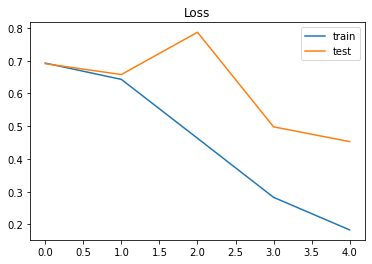

In [46]:
import matplotlib.pyplot as plt
#visualizing the performance of the model
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();
